# Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# First look at the data

In [2]:
df = pd.read_csv("tankerkoenig-data/stations/stations.csv")
df.columns

Index(['uuid', 'name', 'brand', 'street', 'house_number', 'post_code', 'city',
       'latitude', 'longitude'],
      dtype='object')

# Getting the id for my City

In [3]:
uuid = str(df[df['city'] == 'Bann']['uuid'].to_numpy()[0])
print(uuid)

b256bac4-d070-4c6d-b1d9-f70aea3f39dc


# Getting the data belonging to the id 
(+ saving because this cell takes a long time)

In [4]:
# get data only for gasstation with uuid == 'b256bac4-d070-4c6d-.b1d9-f70aea3f39dc'

data = pd.DataFrame(columns = ['date', 'e5', 'diesel', 'e10'])

files = []
for (dirpath, dirnames, filenames) in os.walk("tankerkoenig-data/prices"):
    for file in filenames:
        files.append(dirpath+'/'+file)

counter = 0
for file in files[::-1]:
    counter += 1
    if counter % 25 == 0:
        print("progress: " + str(round(counter/len(files), 2)) + "     " + str(counter) + "/" + str(len(files)))
    df = pd.read_csv(file)
    if uuid in df.values:
        new = df[df['station_uuid'] == uuid][['date', 'e5', 'diesel', 'e10']]
        # append row to the dataframe
        data = data.append(new, ignore_index=True)

data.to_csv("data.csv")

progress: 0.01     25/2502
progress: 0.02     50/2502
progress: 0.03     75/2502
progress: 0.04     100/2502
progress: 0.05     125/2502
progress: 0.06     150/2502
progress: 0.07     175/2502
progress: 0.08     200/2502
progress: 0.09     225/2502
progress: 0.1     250/2502
progress: 0.11     275/2502
progress: 0.12     300/2502
progress: 0.13     325/2502
progress: 0.14     350/2502
progress: 0.15     375/2502
progress: 0.16     400/2502
progress: 0.17     425/2502
progress: 0.18     450/2502
progress: 0.19     475/2502
progress: 0.2     500/2502
progress: 0.21     525/2502
progress: 0.22     550/2502
progress: 0.23     575/2502
progress: 0.24     600/2502
progress: 0.25     625/2502
progress: 0.26     650/2502
progress: 0.27     675/2502
progress: 0.28     700/2502
progress: 0.29     725/2502
progress: 0.3     750/2502
progress: 0.31     775/2502
progress: 0.32     800/2502
progress: 0.33     825/2502
progress: 0.34     850/2502
progress: 0.35     875/2502
progress: 0.36     900/250

# Load data without running the cell above to save time

In [5]:
data = pd.read_csv("data.csv")
data.index = data['date']
data.index = pd.to_datetime(data.index)
data.drop(['Unnamed: 0', 'date'], inplace=True, axis=1)
data.head()

,e5,diesel,e10
date,,,
2019-12-30 14:01:08+01:00,1.399,1.259,0.0
2019-12-25 18:25:24+01:00,1.399,1.259,0.0
2019-12-22 18:47:04+01:00,1.399,1.259,0.0
2019-12-04 23:56:04+01:00,1.399,1.259,0.0
2019-11-29 05:39:04+01:00,1.429,1.279,0.0


# Remove timezone from data

In [6]:
data.index = pd.Index([i.replace(tzinfo=None) for i in data.index])
data.head()

,e5,diesel,e10
2019-12-30 14:01:08,1.399,1.259,0.0
2019-12-25 18:25:24,1.399,1.259,0.0
2019-12-22 18:47:04,1.399,1.259,0.0
2019-12-04 23:56:04,1.399,1.259,0.0
2019-11-29 05:39:04,1.429,1.279,0.0


# Looking only at e5

In [7]:
data.drop(['e10', 'diesel'], inplace=True, axis=1)
data.head()

,e5
2019-12-30 14:01:08,1.399
2019-12-25 18:25:24,1.399
2019-12-22 18:47:04,1.399
2019-12-04 23:56:04,1.399
2019-11-29 05:39:04,1.429


# Interpolate missing data so we get an hourly spaced time series 
(The raw data set consists of gasoline prices whenever the station changes the price.
Sometimes these price changes occur often and sometimes they occur only sporadically. 
Therefor we interpolate the time series to get an hourly spaced time series.
The resulting time series can then be used to extract features and for the statistics)

In [8]:
def find_round_direction(time_1):
    time_2 = time_1.replace(minute=30)
    return round(int(time_2.minute - time_1.minute))

def round_datetime(time_1):
    if find_round_direction(time_1) < 0:
        time_1 = time_1.replace(minute=0).replace(second=0)
    else:
        time_1 = time_1.replace(minute=0).replace(second=0) + datetime.timedelta(hours=1)
    return time_1

t = data.index
start = round_datetime(data.index[0].replace(tzinfo=None))
end = round_datetime(data.index[-1].replace(tzinfo=None))
r = pd.Index(pd.date_range(end, start, freq='H'), name=t.name)
data = data.reindex(t.union(r)).interpolate('index').loc[r]
data.index.name = 'date'
data = data[1:]
data

,e5
date,
2014-06-08 10:00:00,1.578883
2014-06-08 11:00:00,1.578179
2014-06-08 12:00:00,1.577474
2014-06-08 13:00:00,1.576770
2014-06-08 14:00:00,1.576066
...,...
2019-12-30 11:00:00,1.399000
2019-12-30 12:00:00,1.399000
2019-12-30 13:00:00,1.399000


# Extract features

In [9]:
# transform from type str to [datetime, seconds, year, month, day, hour, weekday]
def transform_date(date):
    #a = datetime.datetime.strptime(date[0:-3], "%Y-%m-%d %H:%M:%S")
    a = date
    return (a-zero).total_seconds(), a.year, a.month, a.day, a.hour+a.minute/60+a.second/3600, a.weekday()

def extract_features(df):
    dates_float = []
    years = []
    months = []
    days = []
    hours = []
    weekdays = []
    for date in df.index:
        total_seconds, year, month, day, hour, weekday = transform_date(date)
        dates_float.append(total_seconds)
        years.append(year)
        months.append(month)
        days.append(day)
        hours.append(hour)
        weekdays.append(weekday)
        
    df['date_float'] = dates_float
    df['year'] = years
    df['month'] = months
    df['day'] = days
    df['hour'] = hours
    df['weekday'] = weekdays
    
    return df
      

zero = datetime.datetime(2018, 1, 1, 0, 0, 0)
data = extract_features(data)
data = data.sort_values(by=['date_float'])
data

,e5,date_float,year,month,day,hour,weekday
date,,,,,,,
2014-06-08 10:00:00,1.578883,-112543200.0,2014,6,8,10.0,6
2014-06-08 11:00:00,1.578179,-112539600.0,2014,6,8,11.0,6
2014-06-08 12:00:00,1.577474,-112536000.0,2014,6,8,12.0,6
2014-06-08 13:00:00,1.576770,-112532400.0,2014,6,8,13.0,6
2014-06-08 14:00:00,1.576066,-112528800.0,2014,6,8,14.0,6
...,...,...,...,...,...,...,...
2019-12-30 11:00:00,1.399000,62938800.0,2019,12,30,11.0,0
2019-12-30 12:00:00,1.399000,62942400.0,2019,12,30,12.0,0
2019-12-30 13:00:00,1.399000,62946000.0,2019,12,30,13.0,0


# Plotting e5 price time series

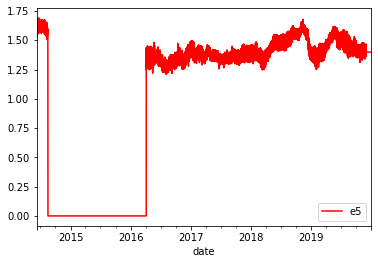

In [10]:
data.plot(kind='line', y=['e5'], color=['red'], use_index=True)
plt.show()

# The data between 2015 and 2016 is missing -> drop it

In [11]:
data = data[data.index >= "2016-05-1"]
data.head()

,e5,date_float,year,month,day,hour,weekday
date,,,,,,,
2016-05-01 00:00:00,1.413937,-52704000.0,2016,5,1,0.0,6
2016-05-01 01:00:00,1.403663,-52700400.0,2016,5,1,1.0,6
2016-05-01 02:00:00,1.393388,-52696800.0,2016,5,1,2.0,6
2016-05-01 03:00:00,1.383114,-52693200.0,2016,5,1,3.0,6
2016-05-01 04:00:00,1.372840,-52689600.0,2016,5,1,4.0,6


# Plotting e5 from 2016 on

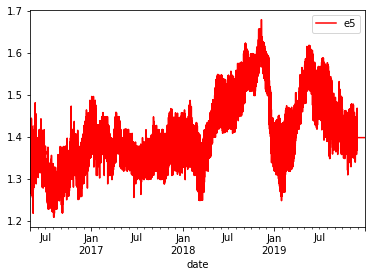

In [12]:
data.plot(kind='line', y=['e5'], color=['red'], use_index=True)
plt.show()

# The following plots show some statistics on e5 prices.

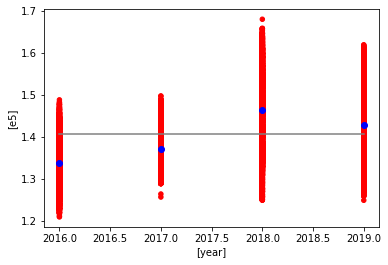

In [13]:
# calculate average e5 price overall
avg_e5 = data['e5'].mean()

color = []
for _ in range(len(data)):
    color.append('red')
    
data.plot(kind='scatter',x=['year'],y=['e5'], color=color)
plt.plot([2016, 2019], [avg_e5, avg_e5], c='gray')
for year in range(data['year'].min(), data['year'].max()+1):
    plt.scatter(year, data[data['year'] == year]['e5'].mean(), c='blue')
plt.show()

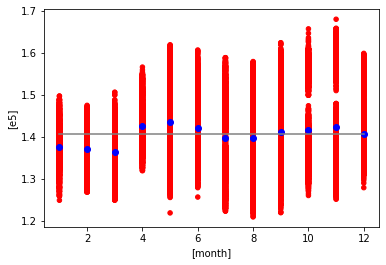

In [14]:
data.plot(kind='scatter',x=['month'],y=['e5'], color=color)
plt.plot([1, 12], [avg_e5, avg_e5], c='gray')
for month in range(data['month'].min(), data['month'].max()+1):
    plt.scatter(month, data[data['month'] == month]['e5'].mean(), c='blue')
plt.show()

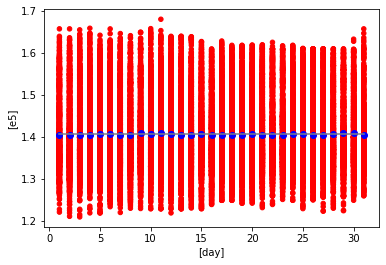

In [15]:
data.plot(kind='scatter',x=['day'],y=['e5'], color=color)
plt.plot([1, 31], [avg_e5, avg_e5], c='gray')
for day in range(data['day'].min(), data['day'].max()+1):
    plt.scatter(day, data[data['day'] == day]['e5'].mean(), c='blue')
plt.show()

0 1.4085746596510904
1 1.4039184328325862
2 1.402156277773974
3 1.4018066222739982
4 1.4043533021145276
5 1.4052624601468666
6 1.4126272553941446


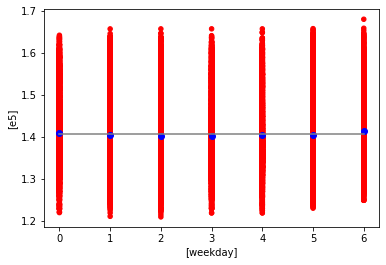

In [16]:
data.plot(kind='scatter',x=['weekday'],y=['e5'], color=color)
plt.plot([0, 6], [avg_e5, avg_e5], c='gray')
for weekday in range(data['weekday'].min(), data['weekday'].max()+1):
    plt.scatter(weekday, data[data['weekday'] == weekday]['e5'].mean(), c='blue')
    print(weekday, data[data['weekday'] == weekday]['e5'].mean())
plt.show()
# monday = 0, tuesday = 1, ...

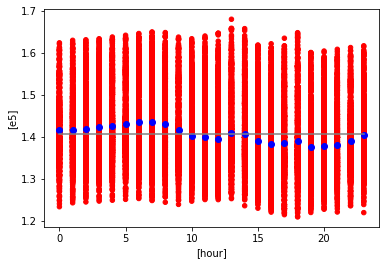

In [17]:
data.plot(kind='scatter',x=['hour'],y=['e5'], color=color)
plt.plot([0, 23], [avg_e5, avg_e5], c='gray')
for hour in range(0, 24):
    plt.scatter(hour, data[data['hour'] == hour]['e5'].mean(), c='blue')
plt.show()

# Key takeaways from the statistics
-> prices are highest at midnight/early morning and lowest in the evening  
-> prices are lower mid week  
-> the day does not have much influence on the price  
-> prices are lowest in the first months of the year  
-> optimal refuel time: wednesday/thursday at around 19 o'clock 

(note that 3.5 years of data is maybe not enough to conclude meaningful results)